# Imports & Setup

In [1]:
import json
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm_notebook as tqdm
#%matplotlib notebook 
%matplotlib inline 

# Helper Functions

In [61]:
#Fast calculate running mean - x is array, N is window
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

#Gets frame from file or already opened capture
def getFrame(video, frame):
    if type(video) is str: 
        cap = cv2.VideoCapture(video)
    else: 
        cap = video

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, frame = cap.read()
    cap.release()
    
    return frame

#Computes the d'th gradient of array-like x
def gradient(x, d=1):
    temp = x
    for i in range(d):
        temp = np.gradient(temp)
    return temp
        

<p>Now we have the tools to capture specific frames, we can find specific points in the video from motion analysis where there is low movement to feed to the CNN</p>

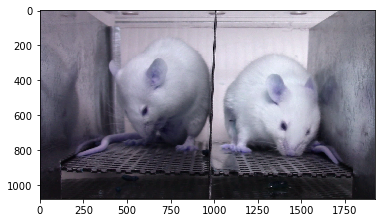

In [3]:
frame = getFrame('esncr.ms12pain51.mp4', 1000)
plt.imshow(frame, cmap=plt.cm.gray)

In [4]:
#Rough function to grab a bunch of images from a video (for training data)
def grab_images(video):
    cap = cv2.VideoCapture(video)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, frame = cap.read()
    height, width = frame.shape[:2]

    for i in tqdm(range(frames)):
        
        ret, frame = cap.read()
    
        #Change this value to determine how often to grab frames
        if i%(90*5) != 0:
            continue
            
        #Videos each contain 2 mouse cages, l & r    
        left = frame[:, :int(width/2)]
        right = frame[:, int(width/2):]
        cv2.imwrite('imgs/' + video + 'l' + str(int(i/(60*5))) + '.jpg', left)
        cv2.imwrite('imgs/' + video + 'r' + str(int(i/(60*5))) + '.jpg', right)
        
    cap.release()
    
#grab_images(video = 'video2.mp4')
#grab_images(video = 'video3.mp4')

# Motion Analysis

In [11]:
#tracks movement over time of mouse in two-cage setup
def calculate_motion(video, data = [], show_frames = False, learning_rate = 0.0):
    
    data.clear()
    
    if show_frames:
        cv2.startWindowThread()
    
    #open the video in opencv and create the mask -- mask options?
    cap = cv2.VideoCapture(video)
    fgbg1 = cv2.createBackgroundSubtractorMOG2()

    #total number of frames in video
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    #grab one frame to determing height and width - don't want to calculate every time
    ret, frame = cap.read()
    height, width = frame.shape[:2]
    
    for i in tqdm(range(frames)):
        
        ret, frame = cap.read()
        
        #If this happens more than a few times, something is wrong with the vid or cv2       
        if not ret:
            print('Failed to capture frame.' + str(i))
            continue
        
        #Shrink the image           v           v   change for other cage
        frame = cv2.resize(frame[:, 0:int(width/2)],None,fx=.4, fy=.4, interpolation = cv2.INTER_AREA)
    
        fgmask = fgbg1.apply(frame, learning_rate)

        #Sums the 'changed' pixels over the whole image
        data.append(int(np.sum(fgmask)))
    
        if show_frames:
            cv2.imshow('original',frame)
            cv2.imshow('frame - MOG',fgmask)
    
            c = cv2.waitKey(1)
            if 'q' == chr(c & 255):
                break  
    
    if show_frames:
        cap.release()
        cv2.destroyAllWindows()
    
    #save list as .npy file with same name as video
    np.save(video, data)
    
    return np.array(data)


In [12]:
#pain_data = calculate_motion('esncr.ms12pain51.mp4', learning_rate = 0.01)
#baseline_data = calculate_motion('hpvxb.ms34sham15.mp4', learning_rate = 0.01)

pain_data = np.load('esncr.ms12pain51.mp4.npy')
baseline_data = np.load('hpvxb.ms34sham15.mp4.npy')

Failed to capture frame.60117
Failed to capture frame.60118
Failed to capture frame.60119



Failed to capture frame.60132
Failed to capture frame.60133
Failed to capture frame.60134



In [51]:
def prepare_and_plot(data, running_mean_window = 300, head = None, tail = None):
    
    trimmed_data = data[head:tail]
    
    def runningMeanFast(x, N):
        return np.convolve(x, np.ones((N,))/N)[(N-1):]
    
    running_mean = runningMeanFast(trimmed_data, running_mean_window)
    
    #Normalizing running mean from 0-1
    max_rm = max(running_mean)      
    normalized_rm = [i/max_rm for i in running_mean]
    
    #Normalizing raw data from 0-1
    max_raw = max(trimmed_data)   
    normalized_raw = [i/max_raw for i in trimmed_data]

    plt.plot(normalized_rm, color = 'red')
    plt.plot(normalized_raw, color = 'grey', alpha = 0.1)
    
    #plt.xticks(range(0,int(max(time)+2)))
    plt.xlabel('time (frame)')
    plt.ylabel('movement (normalized)')
    plt.title('Movement tracking')
    plt.show()

## Baseline

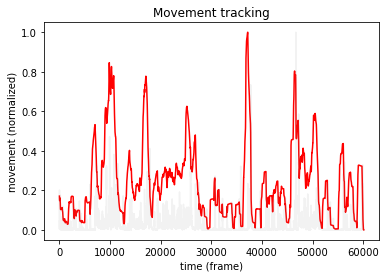

In [52]:
prepare_and_plot(baseline_data, head = 10, running_mean_window = 1000)

## Pain

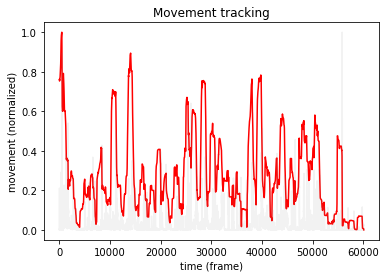

In [53]:
prepare_and_plot(pain_data, head = 10, running_mean_window = 1000)

## Comparison

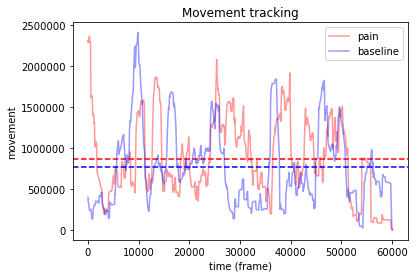

p-value of t-test between pain and baseline data: 5.60484469179e-38


In [63]:
end = min(len(pain_data),len(baseline_data))

pain_rm = runningMeanFast(pain_data, 1*30*60)[:end]
baseline_rm = runningMeanFast(baseline_data, 1*30*60)[:end]

plt.plot(pain_rm, 'r', alpha = 0.4, label = 'pain')
plt.axhline(y=np.average(pain_rm), color='r', linestyle='--')
plt.plot(baseline_rm, 'b', alpha = 0.4, label = 'baseline')
plt.axhline(y=np.average(baseline_rm), color='b', linestyle='--')

plt.xlabel('time (frame)')
plt.ylabel('movement')
plt.title('Movement tracking')
plt.legend()
plt.show()

from scipy import stats
print('p-value of t-test between pain and baseline data:', stats.ttest_ind(pain_data, baseline_data)[1])

<b>Conclusion:</b> The important aspect of this motion analysis is to determine more exactly where to grab frames from over the span of the video. Below is a comparison of low points between the two videos. Low points in the pain video show pain whereas the baseline shows sleeping behavior or just low movement.

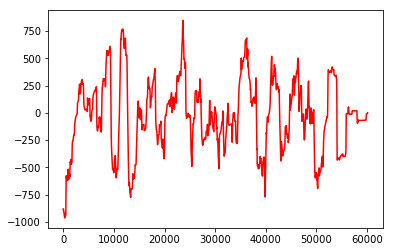

In [62]:
pain_rm_d1 = gradient(pain_rm)
pain_rm_d2 = gradient(pain_rm, 2)
plt.plot(runningMeanFast(pain_rm_d1,1*30*60), color = 'red')
#plt.plot(pain_rm_d2, color = 'blue')

plt.show()
